# Ce notebook s'articule en 5 grandes parties :


###  Importation des packages
###  Définition des fonctions
###  Traitement des images
###  Choix et construction des modèles
###  Implémentation et comparaison des modèles

## Importation des packages

In [1]:
import cv2
from imutils.perspective import four_point_transform
from imutils import contours
import imutils
from matplotlib import pyplot as plt
import numpy as np
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior() 
import os,sys
import pandas as pd
from sklearn import svm
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.neighbors import KNeighborsClassifier

Instructions for updating:
non-resource variables are not supported in the long term


## Définition des fonctions

In [2]:
def auto_canny(image, sigma=0.33):
    # compute the median of the single channel pixel intensities
    v = np.median(image)
    # apply automatic Canny edge detection using the computed median
    lower = int(max(0, (1.0 - sigma) * v))
    upper = int(min(255, (1.0 + sigma) * v))
    edged = cv2.Canny(image, lower, upper)
    # return the edged image
    return edged
def sequence(images,cx,cy):
    
    #gray=cv2.fastNlMeansDenoisingColored(images,None,1,8,3,3)
    #gray=cv2.fastNlMeansDenoisingColored(gray,None,3,1,3,1)

    gray = cv2.cvtColor(images, cv2.COLOR_BGR2GRAY)
    gray=cv2.fastNlMeansDenoising(gray,None,10,7,21)
    threshes =  cv2.adaptiveThreshold(gray,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
            cv2.THRESH_BINARY_INV,11,3)

    edgeds = auto_canny(gray)
    
    kernels = cv2.getStructuringElement(cv2.MORPH_RECT, (cx,cy))
    closeds = cv2.morphologyEx(edgeds, cv2.MORPH_CLOSE, kernels)
    #closeds = cv2.erode(closeds, None, iterations = 1)
    closeds = cv2.dilate(closeds, None, iterations = 3)
    cnts = cv2.findContours(closeds.copy(), cv2.RETR_EXTERNAL,
    cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    cnts_=[cnt for cnt in cnts if cv2.boundingRect(cnt)[2]/images.shape[1]<=0.3 ]
    c = sorted(cnts_, key = cv2.contourArea, reverse = True)[0]
    # compute the rotated bounding box of the largest contour
    rect = cv2.minAreaRect(c)
    box = cv2.cv.BoxPoints(rect) if imutils.is_cv2() else cv2.boxPoints(rect)
    box = np.int0(box)
    all_areas=[cv2.contourArea(rect) for rect in cnts]
    total_area=np.sum(all_areas)
    return cnts,all_areas,closeds,threshes,images,box
def process(images,cx,cy):
    
    #gray=cv2.fastNlMeansDenoisingColored(images,None,1,8,3,3)
    #gray=cv2.fastNlMeansDenoisingColored(gray,None,3,1,3,1)

    gray = cv2.cvtColor(images, cv2.COLOR_BGR2GRAY)
    gray=cv2.fastNlMeansDenoising(gray,None,10,7,21)
    threshes =  cv2.adaptiveThreshold(gray,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
            cv2.THRESH_BINARY_INV,11,3)

    edgeds = auto_canny(gray)
    
    kernels = cv2.getStructuringElement(cv2.MORPH_RECT, (cx,cy))
    closeds = cv2.morphologyEx(edgeds, cv2.MORPH_CLOSE, kernels)
    closeds = cv2.erode(closeds, None, iterations = 1)
    #closeds = cv2.dilate(closeds, None, iterations = 3)
    cnts = cv2.findContours(closeds.copy(), cv2.RETR_EXTERNAL,
    cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    cnts_=[cnt for cnt in cnts if cv2.boundingRect(cnt)[2]/images.shape[1]<=0.3 ]
    all_areas=[cv2.contourArea(rect) for rect in cnts]
    total_area=np.sum(all_areas)
    return cnts,all_areas,closeds,threshes,images
def find_digits(images,cx,cy):
    
    gray = cv2.cvtColor(top, cv2.COLOR_BGR2GRAY)
    #gray=cv2.fastNlMeansDenoising(gray,None,10,7,7)
    threshes =  cv2.adaptiveThreshold(gray,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
            cv2.THRESH_BINARY_INV,255,17)

    edgeds = auto_canny(threshes)

    kernels = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
    clo = cv2.morphologyEx(threshes, cv2.MORPH_CLOSE, kernels)
    cnts = cv2.findContours(clo.copy(), cv2.RETR_EXTERNAL,
    cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    for cnt in cnts:
        x,y,w,h = cv2.boundingRect(cnt)
        imc=top.copy()
        #if (y > 2*image.shape[0]/3) | (y < image.shape[0]/3) & (y+h < image.shape[0]/3):
        #bound the images
        cv2.rectangle(top,(x,y),(x+w,y+h),(0,0,255),1)
    return cnts,all_areas,closeds,threshes,images,box


def draw_countours(image,original,out,cx,cy,digit,Rx,Ry):
    if digit:
        sequantial=find_digits(image,cx,cy)
        
    else:
        sequantial=sequence(image,cx,cy)
    contours=sequantial[0]
    all_areas=sequantial[1]
    image=sequantial[4]
    box=sequantial[5]
    x_,y_,w_,h_=cv2.boundingRect(box)
    x,y,w,h=int(x_/Rx),int(y_/Ry),int(w_/Rx),int(h_/Ry)
    height=[]
    width=[]
    total_area=np.sum(all_areas)
    for cnt in contours:
        #x,y,w,h = cv2.boundingRect(cnt)
        imc=image.copy()
        #if (y > 2*image.shape[0]/3) | (y < image.shape[0]/3) & (y+h < image.shape[0]/3):
        #bound the images
        #cv2.rectangle(image,(x,y),(x+w,y+h),(0,0,255),1)
        cv2.drawContours(imc, [box], -1, (0, 255, 0), 3)
        cv2.imwrite("result/"+out+".jpg",original[y-3:y+h+5,x-3:x+w+3])
        return imc
def resize(image,how,width,height):
    if how=='up':
        image=cv2.resize(image,(int(image.shape[1]*width),int(image.shape[0]*height)))
    elif how=='down':
        image=cv2.resize(image,(int(image.shape[1]/width),int(image.shape[0]/height)))
    else:
        image=cv2.resize(image,(width,height))
    return image,width,height
        
import numpy as np

def next_batch(num, data, labels):
    '''
    Return a total of `num` random samples and labels. 
    '''
    idx = np.arange(0 , len(data))
    np.random.shuffle(idx)
    idx = idx[:num]
    data_shuffle = [data[ i] for i in idx]
    labels_shuffle = [labels[ i] for i in idx]

    return np.asarray(data_shuffle), np.asarray(labels_shuffle)
def get_pos(char):
    return int(char.split('.')[0])

## Traitement des images

In [3]:
im_to_split=cv2.imread("output/r0.jpg")
im_r_to_split=resize(im_to_split,'down',8,8)[0]

    


#im_top=im_r_to_split[:3*int(im_r_to_split.shape[0]/10),:]
im_bottom_ori=im_r_to_split[7*int(im_r_to_split.shape[0]/10):,:]
#im_top=cv2.resize(im_top,(im_top.shape[1]*3,im_top.shape[0]*5))
#im_bottom=cv2.resize(im_bottom,(im_bottom.shape[1]*3,im_bottom.shape[0]*5))

im_bottom_r,Rx,Ry=resize(im_bottom_ori.copy(),'up',3,5)


#im_top=draw_countours(im_top,'top_',50,20,False)
im_bottom_r=draw_countours(im_bottom_r,im_bottom_ori,'code_0',50,20,False,Rx,Ry)
#s_top=sequence(im_top,50,20)
s_bottom=sequence(im_bottom_r,50,20)
#cl_top=s_top[2]
cl_bottom=s_bottom[2]
#cv2.imshow('Top',im_top)
cv2.imshow('Bottom',im_bottom_r)
cv2.waitKey(0)

-1

In [31]:
import pandas as pd
top=cv2.imread("result/code_1.jpg")
top=cv2.resize(top,(top.shape[1]*4,top.shape[0]*2))
gray = cv2.cvtColor(top, cv2.COLOR_BGR2GRAY)
#gray=cv2.fastNlMeansDenoising(gray,None,10,7,7)
threshes =  cv2.adaptiveThreshold(gray,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
        cv2.THRESH_BINARY_INV,15,5)

edgeds = auto_canny(threshes)

kernels = cv2.getStructuringElement(cv2.MORPH_RECT, (3,2))
clo = cv2.morphologyEx(threshes, cv2.MORPH_CLOSE, kernels,iterations=1)
#clo = cv2.erode(clo, None, iterations = 1)
cnts = cv2.findContours(clo.copy(), cv2.RETR_EXTERNAL,
cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
all_areas=[cv2.contourArea(rect) for rect in cnts]

if len(all_areas)<15:
    gray=resize(gray,'up',2,3)[0]
    top_,Rx,Ry=resize(top.copy(),'up',2,3)


    threshes =  cv2.adaptiveThreshold(gray,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
        cv2.THRESH_BINARY_INV,127,40)

    edgeds = auto_canny(threshes)
    threshes= cv2.dilate(threshes, None, iterations = 2)
    kernels = cv2.getStructuringElement(cv2.MORPH_RECT, (8,11))
    clo = cv2.morphologyEx(threshes, cv2.MORPH_CLOSE, kernels,iterations=1)
    #c=sorted(cnts, key = cv2.contourArea, reverse = True)[0]
    #rect = cv2.minAreaRect(c)
    #box = cv2.cv.BoxPoints(rect) if imutils.is_cv2() else cv2.boxPoints(rect)
    #box = np.int0(box)

    cnts = cv2.findContours(clo.copy(), cv2.RETR_EXTERNAL,
    cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    all_areas=[cv2.contourArea(rect) for rect in cnts]
else :
    top_,Rx,Ry=top.copy(),1,1

height=pd.Series([])
width=pd.Series([])
areas_digits=pd.Series([])
for i,cnt in enumerate(cnts[:13]):
    x,y,w,h = cv2.boundingRect(cnt)
    x_,y_,w_,h_=int(x/Rx),int(y/Ry),int(w/Rx),int(h/Ry)
    height[i]=y+h
    width[i]=x+w
    imc=top_.copy()
    #if (y > 2*image.shape[0]/3) | (y < image.shape[0]/3) & (y+h < image.shape[0]/3):
    #bound the images
    if (w/h <=2) & (w/h>=0.1) & (h/imc.shape[0]<0.3) :
        areas_digits[i]=cv2.contourArea(cnt)
        cv2.drawContours(top_, [cnt], -1, (0, 255, 0), 1)
        cv2.rectangle(top_,(x,y),(x+w,y+h),(0,0,255),1)
        cv2.imwrite("digits/"+str(i)+".jpg",top[y_-3:y_+h_+3,x_-3:x_+w_+3])


   
    

cv2.imshow('Top',top)
cv2.imshow('clos',clo)
cv2.waitKey(0)

C:\Users\a020681\Anaconda\lib\site-packages\ipykernel_launcher.py:43: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
C:\Users\a020681\Anaconda\lib\site-packages\ipykernel_launcher.py:44: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
C:\Users\a020681\Anaconda\lib\site-packages\ipykernel_launcher.py:45: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


-1

## Choix et construction des modèles

In [26]:
images=np.loadtxt("../OpenCV_3_KNN_Character_Recognition_Python-master/flattened_images.txt", np.float32)
classes=np.loadtxt("../OpenCV_3_KNN_Character_Recognition_Python-master/classifications.txt", np.float32)
labels=classes.reshape(class_np.size, 1)
classes=[chr(c) for c in classes]
targets=pd.get_dummies(pd.DataFrame(classes)).to_numpy()

In [27]:
classif = OneVsRestClassifier(estimator=SVC(random_state=0))
clf=svm.SVC(gamma=0.0001,C=0.001)
knn = KNeighborsClassifier(n_neighbors=1)
kNearest = cv2.ml.KNearest_create() 
classif.fit(images[66:],classes[66:])
clf.fit(images[66:],classes[66:])
knn.fit(images[66:],classes[66:])
kNearest.train(images, cv2.ml.ROW_SAMPLE,labels)

True

In [33]:
n_input = 600  # input layer (28x28 pixels)
n_hidden1 =  480  # 1st hidden layer
n_hidden2 = 240  # 2nd hidden layer
n_hidden3 = 120   # 3rd hidden layer
n_hidden4 = 60  # 3rd hidden layer
#n_hidden5 = 60  # 3rd hidden layer
n_output = 10  # output layer (0-9 digits)
#hyper parameters
learning_rate = 1e-4
n_iterations =10000
batch_size = 128
dropout = 0.5
...
n_train = len(images[66:])  # 55,000
#n_validation = mnist.validation.num_examples  # 5000
#n_test = mnist.test.num_examples  # 10,000

# init X and y
X = tf.placeholder("float", [None, n_input])
Y = tf.placeholder("float", [None, n_output])
keep_prob = tf.placeholder(tf.float32)

weights = {
    'w1': tf.Variable(tf.truncated_normal([n_input, n_hidden1], stddev=0.1)),
    'w2': tf.Variable(tf.truncated_normal([n_hidden1, n_hidden2], stddev=0.1)),
    'w3': tf.Variable(tf.truncated_normal([n_hidden2, n_hidden3], stddev=0.1)),
    'w4': tf.Variable(tf.truncated_normal([n_hidden3, n_hidden4], stddev=0.1)),
    #'w5': tf.Variable(tf.truncated_normal([n_hidden4, n_hidden5], stddev=0.1)),
    'out': tf.Variable(tf.truncated_normal([n_hidden4, n_output], stddev=0.1)),
}

biases = {
    'b1': tf.Variable(tf.constant(0.1, shape=[n_hidden1])),
    'b2': tf.Variable(tf.constant(0.1, shape=[n_hidden2])),
    'b3': tf.Variable(tf.constant(0.1, shape=[n_hidden3])),
    'b4': tf.Variable(tf.constant(0.1, shape=[n_hidden4])),
  #  'b5': tf.Variable(tf.constant(0.1, shape=[n_hidden5])),
    'out': tf.Variable(tf.constant(0.1, shape=[n_output]))
}


layer_1 = tf.add(tf.matmul(X, weights['w1']), biases['b1'])
layer_2 = tf.add(tf.matmul(layer_1, weights['w2']), biases['b2'])
layer_3 = tf.add(tf.matmul(layer_2, weights['w3']), biases['b3'])
layer_4 = tf.add(tf.matmul(layer_3, weights['w4']), biases['b4'])
#layer_5 = tf.add(tf.matmul(layer_4, weights['w5']), biases['b5'])
layer_drop = tf.nn.dropout(layer_4, keep_prob)
output_layer = tf.matmul(layer_4, weights['out']) + biases['out']

...
cross_entropy = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(
        labels=Y, logits=output_layer
        ))
train_step = tf.train.AdamOptimizer(learning_rate).minimize(cross_entropy)

...
correct_pred = tf.equal(tf.argmax(output_layer, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

...
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

# train on mini batches
for i in range(n_iterations):
    batch_x, batch_y = next_batch(22,images[66:],targets[66:])
    sess.run(train_step, feed_dict={
        X: batch_x, Y: batch_y, keep_prob: dropout
        })

    # print loss and accuracy (per minibatch)
    if i % 100 == 0:
        minibatch_loss, minibatch_accuracy = sess.run(
            [cross_entropy, accuracy],
            feed_dict={X: batch_x, Y: batch_y, keep_prob: 1.0}
            )
        print(
            "Iteration",
            str(i),
            "\t| Loss =",
            str(minibatch_loss),
            "\t| Accuracy =",
            str(minibatch_accuracy)
            )

Iteration 0 	| Loss = 364.92197 	| Accuracy = 0.22727273
Iteration 100 	| Loss = 0.0 	| Accuracy = 1.0
Iteration 200 	| Loss = 0.0 	| Accuracy = 1.0
Iteration 300 	| Loss = 0.0 	| Accuracy = 1.0
Iteration 400 	| Loss = 0.0 	| Accuracy = 1.0
Iteration 500 	| Loss = 0.0 	| Accuracy = 1.0
Iteration 600 	| Loss = 0.0 	| Accuracy = 1.0
Iteration 700 	| Loss = 0.0 	| Accuracy = 1.0
Iteration 800 	| Loss = 0.0 	| Accuracy = 1.0
Iteration 900 	| Loss = 0.0 	| Accuracy = 1.0
Iteration 1000 	| Loss = 0.0 	| Accuracy = 1.0
Iteration 1100 	| Loss = 0.0 	| Accuracy = 1.0
Iteration 1200 	| Loss = 0.0 	| Accuracy = 1.0
Iteration 1300 	| Loss = 0.0 	| Accuracy = 1.0
Iteration 1400 	| Loss = 0.0 	| Accuracy = 1.0
Iteration 1500 	| Loss = 0.0 	| Accuracy = 1.0
Iteration 1600 	| Loss = 0.0 	| Accuracy = 1.0
Iteration 1700 	| Loss = 0.0 	| Accuracy = 1.0
Iteration 1800 	| Loss = 0.0 	| Accuracy = 1.0
Iteration 1900 	| Loss = 0.0 	| Accuracy = 1.0
Iteration 2000 	| Loss = 0.0 	| Accuracy = 1.0
Iteration 21

## Implémentation et comparaison des modèles

OneVsRest Sklearn : 8978229002882
Neural Network Tensorflow : 1978919881691
KNN Sklearn: 8978229002882
KNN OpenCV: 8978229002882


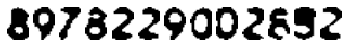

In [32]:
digit_files=os.listdir("digits")
digit_files=sorted(digit_files, key=get_pos,reverse=True)
nn_tf_list,knn_list,knn_cv_list,ovr_list=[],[],[],[]
for i,digit in enumerate(digit_files,1):
    im=cv2.imread("digits/"+digit)
    gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)

    im_r=resize(gray,'t',20,30)[0]

    # get grayscale image
    imgBlurred = cv2.GaussianBlur(im_r, (9,9), 0)                        # blur

                                                        # filter image from grayscale to black and white
    imgThresh = cv2.adaptiveThreshold(imgBlurred,                           # input image
                                      255,                                  # make pixels that pass the threshold full white
                                      cv2.ADAPTIVE_THRESH_GAUSSIAN_C,       # use gaussian rather than mean, seems to give better results
                                      cv2.THRESH_BINARY_INV,                # invert so foreground will be white, background will be black
                                      41,                                   # size of a pixel neighborhood used to calculate threshold value
                                      19)
    imgThreshCopy = imgThresh.copy()   
    npaContours, npaHierarchy = cv2.findContours(imgThreshCopy,        # input image, make sure to use a copy since the function will modify this image in the course of finding contours
                                                     cv2.RETR_EXTERNAL,                 # retrieve the outermost contours only
                                                     cv2.CHAIN_APPROX_SIMPLE) 

    for npaContour in npaContours:                          # for each contour      # if contour is big enough to consider
        [intX, intY, intW, intH] = cv2.boundingRect(npaContour)         # get and break out bounding rect

                                            # draw rectangle around each contour as we ask user for input
        cv2.rectangle(im_r,           # draw rectangle on original training image
                      (intX, intY),                 # upper left corner
                      (intX+intW,intY+intH),        # lower right corner
                      (0, 0, 255),                  # red
                      2)                            # thickness

        imgROI = imgThresh[intY:intY+intH, intX:intX+intW]                                  # crop char out of threshold image
        #imgROIResized = cv2.resize(imgROI, (20, 30))     # resize image, this will be more consistent for recognition and storage

        #cv2.imshow("imgROI", imgROI)                    # show cropped out char for reference
        #cv2.imshow("imgROIResized", imgROIResized)
        #cv2.waitKey(0)
    im_r_to=resize(imgROI,'t',20,30)[0]
    im_r_to_test=im_r_to.reshape((1,30*20))
    im_non_processed=imgThresh.reshape((1,30*20))
    
    plt.subplot(1, 13,i)
    plt.imshow(im_r_to,cmap='Greys')
    plt.axis('off')
    retval, npaResults, neigh_resp, dists = kNearest.findNearest(np.float32(im_r_to_test), k = 1)     # call KNN function find_nearest

    strCurrentChar = str(chr(int(npaResults[0][0]))) 
    prediction = sess.run(tf.argmax(output_layer, 1), feed_dict={X: [im_r_to_test[0]]})
    np.squeeze(prediction)

    nn_tf_list.append(str(np.squeeze(prediction)))

    knn_cv_list.append(strCurrentChar)
    ovr_list.append(classif.predict(im_r_to_test)[0])
#    svc_list.append(clf.predict(im_r_to_test)[0])
    knn_list.append(knn.predict(im_r_to_test)[0])
print('OneVsRest Sklearn : {}'.format(''.join(ovr_list)))
print('Neural Network Tensorflow : {}'.format(''.join(nn_tf_list)))
print('KNN Sklearn: {}'.format(''.join(knn_list)))
print('KNN OpenCV: {}'.format(''.join(knn_cv_list)))
    


plt.show()